In [ ]:
import torch, torch.nn.functional as F, matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Xtr, Ytr, Xte, Yte = torch.load('/content/drive/MyDrive/MNIST')
Xtr /= 255.0
Xte /= 255.0
class Relu:
  def __call__(self, x):
    self.zero = torch.tensor(0).float()
    self.out = torch.maximum(x, self.zero)
    return self.out
  def parameters(self):
    return []

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class LeakyRelu:
  def __init__(self, alpha = 1e-2):
    self.alpha = alpha
  def __call__(self, x):
    self.out = torch.maximum(x * self.alpha, x)
    return self.out
  def parameters(self):
    return []

class Linear:
  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  def __call__(self, x):
    self.out = x.reshape(x.shape[0], -1) @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:

NOISE_DIM = 96

def sample_noise(batch_size, dim):
  return 2 * torch.rand((batch_size, dim)) - 1

def discriminator():
  model = None
  model = [
      Linear(784, 256),LeakyRelu(),
      Linear(256, 256),LeakyRelu(),
      Linear(256, 1)
      ]
  with torch.no_grad():
    model[-1].weight *=0.1
    for layer in model[:-1]:
      if isinstance(layer, Linear):
        layer.weight *= 2**0.5
  return model


def generator(noise_dim=NOISE_DIM):
    model = None
    model = [
        Linear(noise_dim, 1024), Relu(),
        Linear(1024, 1024), Relu(),
        Linear(1024, 784), Tanh()
        ]

    with torch.no_grad():
      for layer in model[:-2]:
        if isinstance(layer, Linear):
          layer.weight *= 2**0.5
    return model

def discriminator_loss(logits_real, logits_fake):
    loss = None
    logits_fake = logits_fake.flatten()
    logits_real = logits_real.flatten()
    real_loss = F.binary_cross_entropy_with_logits(logits_real, torch.ones_like(logits_real))
    fake_loss = F.binary_cross_entropy_with_logits(logits_fake, torch.zeros_like(logits_fake))
    loss = real_loss + fake_loss
    return loss



def generator_loss(logits_fake):
    loss = None

    logits_fake = logits_fake.flatten()
    loss = F.binary_cross_entropy_with_logits(logits_fake, torch.ones_like(logits_fake))

    return loss

In [ ]:
batch_size = 128
noise_size = 96

discriminator_model = discriminator()
generator_model = generator()

model = discriminator_model + generator_model

parameters = [p for layer in model for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True

n = len(discriminator_model)

In [ ]:
images = []
epochs = 3750
lr = 1e-2

for i in range(1, epochs + 1):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  real_data = Xtr[ix]

  for p in parameters:
    p.grad = None

  x = 2 * (real_data - 0.5)
  for layer in discriminator_model:
    x = layer(x)

  logits_real = x

  g_fake_seed = sample_noise(batch_size, noise_size)
  x = g_fake_seed
  for layer in generator_model:
    x = layer(x)

  fake_images = x.view(batch_size, 28, 28).detach()

  x = fake_images

  for layer in discriminator_model:
    x = layer(x)

  logits_fake = x
  d_total_error = discriminator_loss(logits_real, logits_fake)
  d_total_error.backward()

  # Vanilla update
  for p in parameters[:n]:
    p.data += -lr * p.grad

  for p in parameters:
    p.grad = None

  g_fake_seed = sample_noise(batch_size, noise_size)
  x = g_fake_seed
  for layer in generator_model:
    x = layer(x)

  fake_images = x.view(batch_size, 28, 28)

  x = fake_images

  for layer in discriminator_model:
    x = layer(x)

  gen_logits_fake = x

  g_error = generator_loss(gen_logits_fake)
  g_error.backward()
  # Vanilla Updat
  for p in parameters[n:]:
    p.data += -lr * p.grad


  if i % 250 == 0:
    print(f"d_total_error:{d_total_error.item()}, g_error{g_error.item()}")
    imgs_numpy = fake_images.data.cpu().numpy()
    images.append(imgs_numpy[0])


d_total_error:0.954391360282898, g_error3.6056418418884277
d_total_error:0.800530731678009, g_error3.5619027614593506
d_total_error:0.8331555128097534, g_error1.3068108558654785
d_total_error:0.8046358227729797, g_error0.9599894285202026
d_total_error:0.7103811502456665, g_error3.097625970840454
d_total_error:0.683330237865448, g_error2.250621795654297
d_total_error:0.837365984916687, g_error1.2292594909667969
d_total_error:0.6336296796798706, g_error2.7513208389282227
d_total_error:0.5239863395690918, g_error2.295849323272705
d_total_error:0.7913656234741211, g_error0.9154954552650452
d_total_error:0.44074684381484985, g_error2.030156373977661
d_total_error:0.6147280931472778, g_error1.68159818649292
d_total_error:0.5765547156333923, g_error2.6457982063293457
d_total_error:0.6091983318328857, g_error3.353832483291626
d_total_error:0.49754849076271057, g_error2.417693614959717


Iter: 0


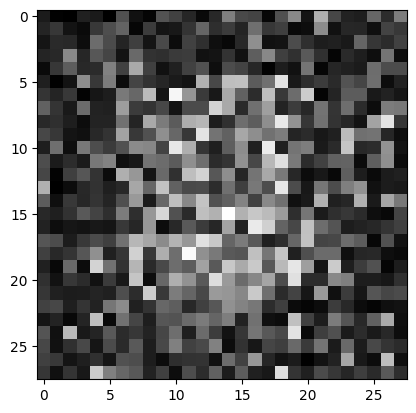


Iter: 250


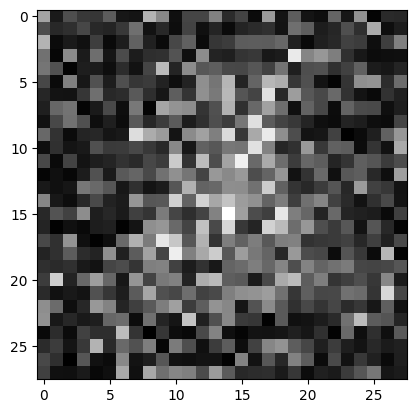


Iter: 500


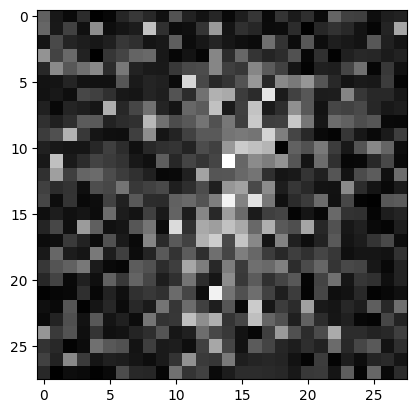


Iter: 750


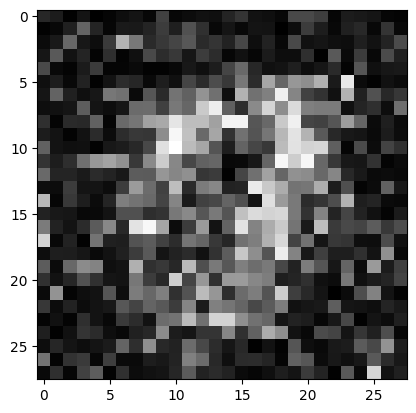


Iter: 1000


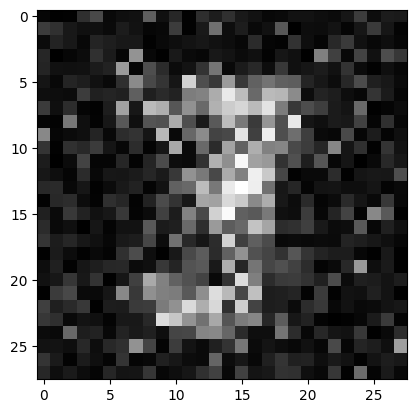


Iter: 1250


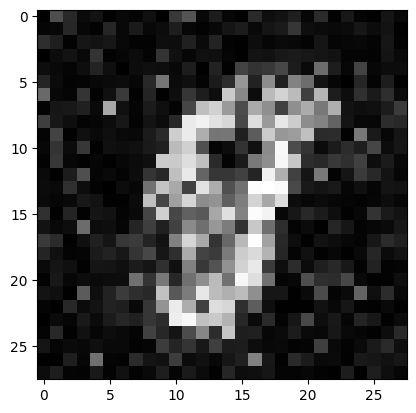


Iter: 1500


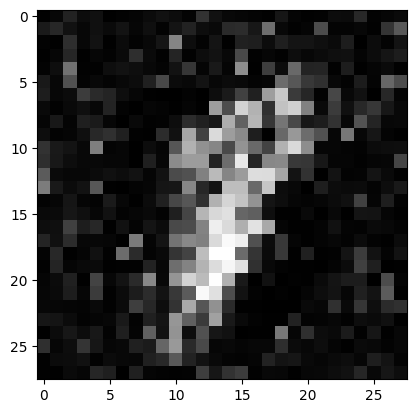


Iter: 1750


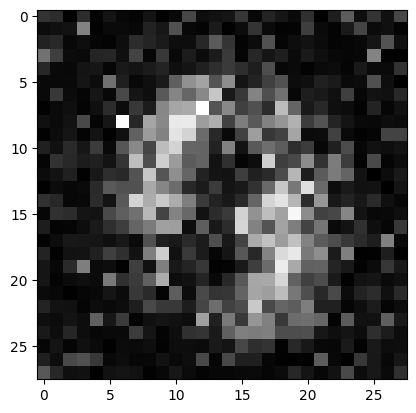


Iter: 2000


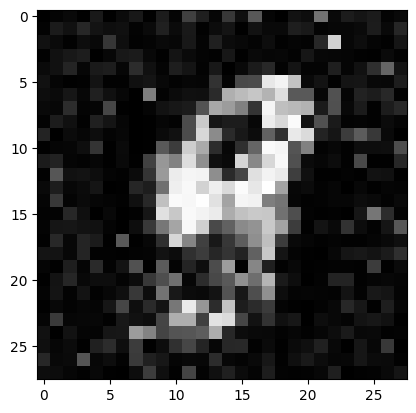


Iter: 2250


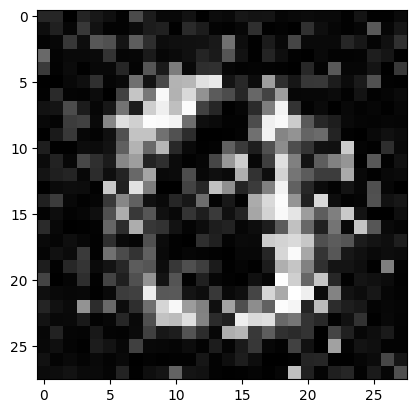


Iter: 2500


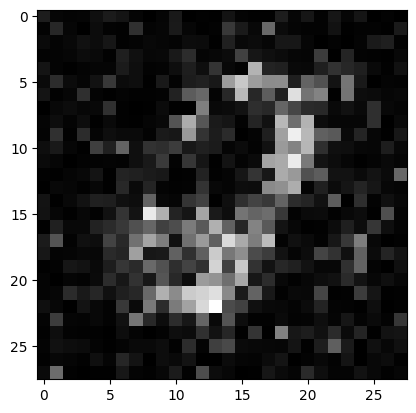


Iter: 2750


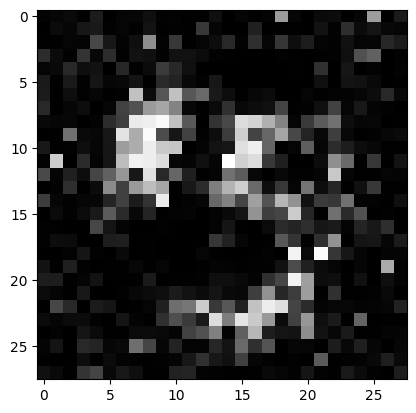


Iter: 3000


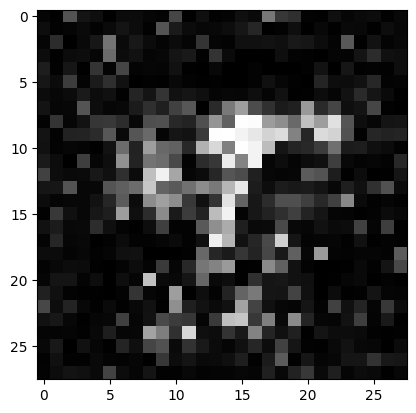


Iter: 3250


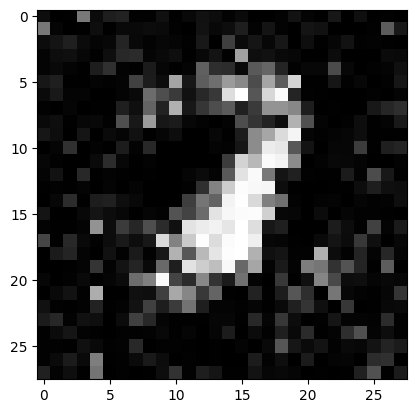


Iter: 3500


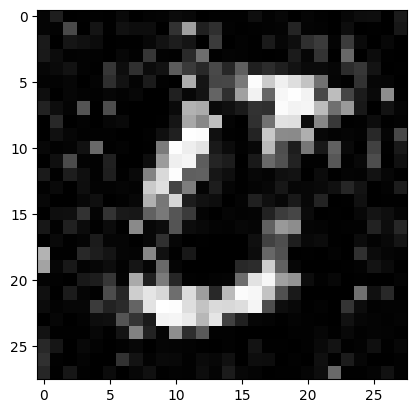

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    plt.imshow(img, cmap='gray')
    plt.show()
    numIter += 250
    print()